In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import tensorflow as tf
import numpy as np
import cv2

import rcnn.simple_nn as nn
from rcnn.MOT_parser import get_data
from rcnn.data_generators import get_anchor, video_streamer

import pickle


from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
from random import seed
seed(12345)
np.random.seed(12345)

In [4]:
data,_,_ = get_data(['/tmp/MOT17/'], form='jpg')

Parsing annotation files


In [5]:
with open('config.pickle', 'rb') as f:
    C = pickle.load(f)

#C.rpn_stride = 8
#C.im_size = 256

In [6]:
#C.anchor_box_ratios = [[150, 300]]

#C.anchor_box_scales = np.arange(0.05, 1.1, 0.1)
print(C.anchor_box_ratios, C.anchor_box_scales)

[[150, 300]] [ 0.15  0.35  0.55  0.75  0.95]


In [7]:
data_gen = video_streamer(data, 2, C, lambda x,y: [x//C.rpn_stride,y//C.rpn_stride], 'tf', 'test', frame_batchsize=8)

In [8]:
x = next(data_gen)

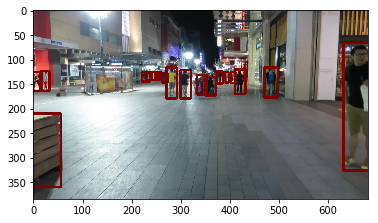

In [9]:
t = 3
im = x[0][0,t].copy()
im -= im.min()
im /= im.max()

bbs = x[-1][0][t]['bboxes']
for bb in bbs:
    a,b,c,d = map(lambda x: int(x/(1080/C.im_size)), [bb['x1'], bb['y1'], bb['x2'], bb['y2']])
    im -= im.min()
    im /= im.max()
    cv2.rectangle(im, (a,b), (c,d), color=0.5, thickness=3)
    #im[b:d,a:c] = np.array([0,255,0], dtype='float32')/255
plt.imshow(im)
plt.show()

In [10]:
bbs[:5]

[{'class': 'bbox', 'x1': 1158, 'x2': 1216, 'y1': 340, 'y2': 480},
 {'class': 'bbox', 'x1': 764, 'x2': 826, 'y1': 327, 'y2': 505},
 {'class': 'bbox', 'x1': 845, 'x2': 903, 'y1': 343, 'y2': 506},
 {'class': 'bbox', 'x1': 1326, 'x2': 1401, 'y1': 327, 'y2': 500},
 {'class': 'bbox', 'x1': 1780, 'x2': 2013, 'y1': 191, 'y2': 918}]

In [11]:
num_anchors = len(C.anchor_box_ratios) * len(C.anchor_box_scales)

In [12]:
x[1][0][0,0].shape

(24, 42, 10)

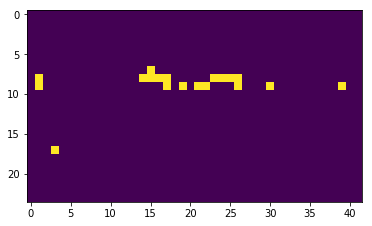

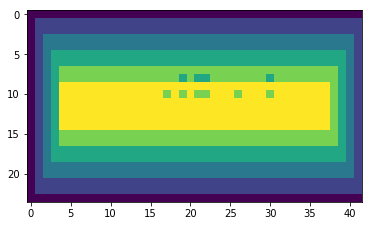

In [13]:
plt.imshow((x[1][0][0,t][...,-num_anchors:]).sum(axis=-1))
plt.show()
plt.imshow((x[1][0][0,t][...,:-num_anchors]).sum(axis=-1))
plt.show()

In [14]:
sess = tf.Session()

In [15]:
video_input = tf.placeholder(tf.float32, [None,None,None,None,3], name='video_input')
roi_input = tf.placeholder(tf.int64, [None,None,4], name='roi_input')
feature_map_input = tf.placeholder(tf.float32, [1, None, None, nn.shared_dim], 'feature_map_input')

In [16]:
C.num_rois = 32

In [17]:
base, base_model = nn.build_shared(video_input, stop_gradient=True)
rpn = nn.build_rpn(base, num_anchors)

classifier = nn.classifier(roi_input, C.num_rois, nb_classes=len(C.class_mapping), trainable=False)(feature_map_input)

In [18]:
base_model.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [19]:
saver = tf.train.Saver()

In [20]:
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}

print(class_mapping)

class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'bbox', 1: 'bg'}


In [21]:
rpn[0] = tf.nn.sigmoid(rpn[0])
classifier[0] = tf.nn.softmax(classifier[0])

#ROIs = []

def predict_rpn_and_featuremap(X):
    return sess.run(rpn + [base], {video_input:X})

def predict_classifier(features, ROI):
    #global ROIs
    #ROIs.append(ROI)
    return sess.run(classifier, {feature_map_input: features, roi_input:ROI})

In [22]:
saver.restore(sess, './experiment_save/with_det')

INFO:tensorflow:Restoring parameters from ./experiment_save/with_det


In [23]:
from rcnn.prediction_to_bb import extract_for_det, extract_for_rpn

In [24]:
extract_for_rpn(x[0][0], C)
print('1')

1


In [25]:
preds_n_base = predict_rpn_and_featuremap(x[0])

In [26]:
Y1, Y2, base_ = preds_n_base

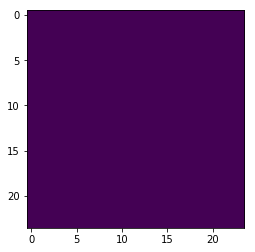

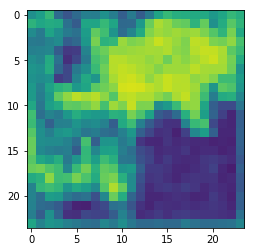

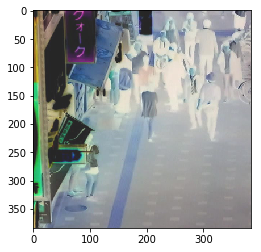

In [32]:
t = 3
plt.imshow((x[1][0][0,t][...,num_anchors:]).sum(axis=-1))
plt.show()
plt.imshow(Y1[0,t].max(axis=-1), vmin=0, vmax=1)
plt.show()
plt.imshow(x[0][0,t] - x[0][0,t].min())
plt.show()

In [33]:
bbs = extract_for_det(Y1[:,t], Y2[:,t], base_[:,t], predict_classifier, C)

In [34]:
bbs

[[160, 32, 240, 208],
 [144, 32, 208, 192],
 [128, 48, 160, 176],
 [128, 48, 192, 224],
 [224, 64, 256, 176],
 [256, 0, 352, 208],
 [240, 80, 272, 192],
 [288, 16, 336, 160],
 [64, 128, 80, 176],
 [336, 32, 368, 144],
 [256, 80, 304, 208],
 [80, 128, 96, 176],
 [224, 64, 240, 112],
 [208, 64, 240, 176],
 [176, 48, 192, 96],
 [192, 32, 256, 192],
 [160, 48, 176, 96],
 [112, 128, 128, 176],
 [240, 32, 304, 192],
 [304, 32, 352, 144],
 [112, 32, 176, 192],
 [208, 48, 224, 112],
 [176, 48, 208, 176],
 [208, 32, 224, 80],
 [192, 64, 208, 112],
 [192, 32, 208, 80],
 [272, 0, 320, 144],
 [240, 32, 256, 96],
 [112, 144, 128, 192],
 [240, 16, 256, 64],
 [304, 16, 336, 112],
 [192, 64, 224, 192],
 [352, 32, 368, 96],
 [0, -16, 48, 64],
 [256, 96, 272, 176],
 [224, 80, 240, 144],
 [288, 0, 304, 32],
 [320, 32, 336, 96],
 [288, 16, 304, 64],
 [64, 256, 112, 336],
 [240, 0, 288, 112],
 [240, 64, 256, 112],
 [16, 240, 64, 352],
 [176, 32, 192, 80],
 [336, 48, 352, 96],
 [80, 112, 96, 160],
 [352, 0,

In [35]:
preds = predict_rpn_and_featuremap(x[0])[0]

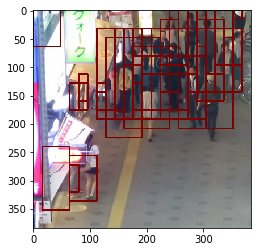

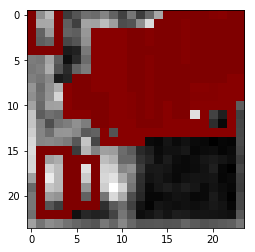

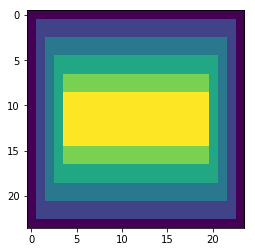

In [36]:
for im, real in [(x[0][0,t] - x[0][0,t].min(), True), (np.stack([preds[0,t].max(axis=-1)]*3,  axis=-1), False)]:
    for bb in bbs:
        a,b,c,d = map(lambda x: x//C.rpn_stride, bb)
        
        if real:
            a,b,c,d = map(lambda x: x*C.rpn_stride, [a,b,c,d])
            
        im -= im.min()
        im /= im.max()
        
        thick = 1
        if real:
            thick = 2
            
        cv2.rectangle(im, (a,b), (c,d), color=0.5, thickness=thick)
        #im[b:d,a:c] = np.array([0,255,0], dtype='float32')/255
    plt.imshow(im, vmin=0, vmax=1)
    plt.show()
plt.imshow((x[1][0][0,t][...,:num_anchors]).sum(axis=-1))
plt.show()